<center>DataSet Cleaner</center>

**Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import ADASYN
from sentence_transformers import SentenceTransformer

import xgboost as xgb
from scipy.stats import chi2_contingency, pointbiserialr, f_oneway
import random
from collections import Counter
from ipywidgets import interact


In [5]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

**Load the Training Dataset**


In [84]:
train = pd.read_csv('DataSet/Hackathon_Train.csv')
train.head(2)

,Post_ID,Pseudo_Caption,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Viral
0,Post_574,youtube Video about #Gaming posted in Canada,2022-10-10,YOUTUBE,#Gaming,Video,Canada,3620989.0,185166.0,73884.0,46247.0,0
1,Post_2708,tiktok Live Stream about #Education posted in ...,2023-11-07,Tiktok,#Education,Live Stream,INDIA,1876306.0,149927.0,65747.0,27923.0,1


**Dataset Overview**

The dataset contains 4,500 rows and 11 columns including Post_ID, Pseudo_Caption, Post_Date, Platform, Hashtag, Content_Type, Region, and engagement metrics (Views, Likes, Shares, Comments) plus the target variable (Viral).

In [7]:
print("Dataset shape:", train.shape)
print(list(train.columns))

Dataset shape: (4500, 12)
['Post_ID', 'Pseudo_Caption', 'Post_Date', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Viral']


**Platform Distribution**

In [8]:
train['Platform'].value_counts()

Platform
  youtube        313
  tiktok         308
TWITTER          307
Youtube          293
instagram        289
YOUTUBE          289
tiktok           288
  twitter        288
youtube          285
INSTAGRAM        284
TIKTOK           271
Tiktok           265
Instagram        261
  instagram      260
twitter          258
Twitter          241
Name: count, dtype: int64

**Hashtag Distribution**

In [9]:
print(train['Hashtag'].value_counts())

Hashtag
#Fitness      463
#Education    458
#Challenge    436
#Comedy       434
#Fashion      419
#Dance        419
#Music        418
#Tech         417
#Viral        406
#Gaming       405
#unknown       62
#none          59
#misc          56
#error         48
Name: count, dtype: int64


**Content Type Distribution**

In [10]:
print(train['Content_Type'].value_counts())

Content_Type
Live Stream    771
Post           769
Video          747
Reel           746
Tweet          745
Shorts         722
Name: count, dtype: int64


**Region Distribution**


In [11]:
print(train['Region'].value_counts())

Region
  Brazil         163
usa              157
USA              156
uk               156
  Canada         155
CANADA           152
Canada           152
BRAZIL           151
Australia        150
  USA            149
india            149
Usa              148
INDIA            145
Japan            142
  UK             142
brazil           140
Uk               140
India            139
japan            138
  Australia      138
UK               136
Brazil           136
canada           134
AUSTRALIA        134
germany          130
  Germany        128
  Japan          127
  India          126
australia        124
GERMANY          122
JAPAN            121
Germany          120
Name: count, dtype: int64


**Define Cleaning Function**

Creating a helper function to standardize text columns by trimming whitespace and converting to lowercase.

In [12]:
# Syntax Error Handler
def clean_column(column):
	train[column] = train[column].str.strip().str.lower()

**Standardize Column Names**

Cleaning the Text columns to ensure consistent naming (all lowercase, no extra spaces). This groups variations like "YOUTUBE", "youtube", " youtube " into a single category.

In [13]:
clean_column('Platform')
clean_column('Content_Type')
clean_column('Hashtag')
clean_column('Region')

**Platform Distribution After Cleaning**


In [14]:
print(train['Platform'].value_counts())

Platform
youtube      1180
tiktok       1132
twitter      1094
instagram    1094
Name: count, dtype: int64


**Hashtag Distribution After Cleaning**


In [15]:
print(train['Hashtag'].value_counts())

Hashtag
#fitness      463
#education    458
#challenge    436
#comedy       434
#fashion      419
#dance        419
#music        418
#tech         417
#viral        406
#gaming       405
#unknown       62
#none          59
#misc          56
#error         48
Name: count, dtype: int64


**Content Type Distribution After Cleaning**

In [16]:
print(train['Content_Type'].value_counts())


Content_Type
live stream    771
post           769
video          747
reel           746
tweet          745
shorts         722
Name: count, dtype: int64


**Region Distribution**

In [17]:
print(train['Region'].value_counts())

Region
usa          610
canada       593
brazil       590
uk           574
india        559
australia    546
japan        528
germany      500
Name: count, dtype: int64


**Check for Duplicate Records**

In [18]:
duplicates = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


**Handle Dates**

Date Column has some invalid entries `invalid_date` that need to be addressed. 

In [19]:
invalid_date = train['Post_Date'] == 'invalid_date'
print(f"Invalid dates found: {invalid_date.sum()}")

Invalid dates found: 135


## Handling Missing Values

After inspecting the dataset, we found that several key features have missing values:

- `Views`: 135 missing entries  
- `Likes`: 135 missing entries  
- `Shares`: 135 missing entries  
- `Comments`: 135 missing entries  

These features are **critical for our model**, as they directly represent user engagement metrics. Missing values in these columns could significantly affect model performance and accuracy.  

**Decision:**  
To ensure data quality and maintain reliable model training, we will **remove the rows with missing values** in these important features.


In [20]:
train[invalid_date].isnull().sum()

Post_ID             0
Pseudo_Caption      0
Post_Date           0
Platform            0
Hashtag             0
Content_Type        0
Region              0
Views             135
Likes             135
Shares            135
Comments          135
Viral               0
dtype: int64

**Dropping Rows with Invalid Dates**

In [21]:
train = train[~invalid_date]

**Pseudo_Caption Inspection**

Extracting unique values from the Pseudo_Caption column to identify patterns and inconsistencies.

In [22]:
# Lowercase and strip whitespace
clean_column('Pseudo_Caption')

# Extract features from Pseudo_Caption
train['parsed_platform'] = train['Pseudo_Caption'].str.split().str[0]
train['parsed_content_type'] = train['Pseudo_Caption'].str.extract(r'^\w+\s+(.+?)\s+about')[0]
train['parsed_hashtag'] = train['Pseudo_Caption'].str.extract(r'(#\w+)')[0]
train['parsed_region'] = train['Pseudo_Caption'].str.extract(r'posted in (.+)$')[0]

# Compare with existing columns just an example
train[['parsed_platform', 'Platform']].head(2)

,parsed_platform,Platform
0,youtube,youtube
1,tiktok,tiktok


In [23]:
# Compare with existing columns
match_rates = {
    'Platform': (train['Platform'] == train['parsed_platform']).mean() * 100,
    'Content_Type': (train['Content_Type'] == train['parsed_content_type']).mean() * 100,
    'Region': (train['Region'] == train['parsed_region']).mean() * 100,
    'Hashtag': (train['Hashtag'] == train['parsed_hashtag']).mean() * 100
}

print("Match rates against structured caption extracts:")
for label, rate in match_rates.items():
    matching = int(rate * len(train) / 100)
    print(f"  {label}: {matching} / {len(train)} ({rate:.2f}%)")

Match rates against structured caption extracts:
  Platform: 4365 / 4365 (100.00%)
  Content_Type: 4365 / 4365 (100.00%)
  Region: 4365 / 4365 (100.00%)
  Hashtag: 4274 / 4365 (97.94%)


**Hashtag Invalid Values**

The `Hashtag` column contains invalid entries such as `#misc`,`#error`, `#unknown`, `#none`

In [24]:
hashtag = train['Hashtag'].unique()
print(hashtag)

['#gaming' '#education' '#fashion' '#comedy' '#tech' '#fitness' '#dance'
 '#challenge' '#viral' '#music' '#misc' '#error' '#unknown' '#none']


**Filling Hashtag From Pseudo_Caption**


In [25]:
train["Hashtag"] = train["parsed_hashtag"]

**Dropping Additional Parsed Columns**


In [26]:
train = train.drop(columns=[ 'parsed_platform', 'parsed_content_type', 'parsed_hashtag', 'parsed_region'])
train.head(2)

,Post_ID,Pseudo_Caption,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Viral
0,Post_574,youtube video about #gaming posted in canada,2022-10-10,youtube,#gaming,video,canada,3620989.0,185166.0,73884.0,46247.0,0
1,Post_2708,tiktok live stream about #education posted in ...,2023-11-07,tiktok,#education,live stream,india,1876306.0,149927.0,65747.0,27923.0,1


In [27]:
print(train.columns)


Index(['Post_ID', 'Pseudo_Caption', 'Post_Date', 'Platform', 'Hashtag',
       'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments',
       'Viral'],
      dtype='object')


**Handle Numerical Engagement Columns**

**Clean Engagement Metrics**

The engagement columns (Views, Likes, Shares, Comments) contain numeric values with text suffixes that need to be cleaned and converted to proper numeric format.

- *Example*  `-79715.0 Shares`

In [28]:
engagement = ['Views', 'Likes', 'Shares', 'Comments']

negative_mask = train['Views'].astype(str).str.contains('-', na=False)
train[negative_mask][['Post_ID'] + engagement].head(2)


,Post_ID,Views,Likes,Shares,Comments
9,Post_2164,-628363.0 Views,-74367.0 Likes,-94257.0 Shares,-13383.0 Comments
10,Post_2232,-3371495.0 Views,-283970.0 Likes,-78225.0 Shares,-32830.0 Comments


In [29]:
# Clean engagement metrics - remove text suffixes and convert to numeric
for col in engagement:
    train[col] = train[col].astype(str).str.split().str[0]
    train[col] = pd.to_numeric(train[col], errors='coerce').abs()

print("Engagement columns cleaned and converted to numeric")
train[engagement].head()

Engagement columns cleaned and converted to numeric


,Views,Likes,Shares,Comments
0,3620989.0,185166.0,73884.0,46247.0
1,1876306.0,149927.0,65747.0,27923.0
2,3494450.0,476260.0,92683.0,40176.0
3,2386028.0,156812.0,98830.0,38728.0
4,1831366.0,219055.0,32009.0,33612.0


**Identify Missing Values**

In [30]:
# Check missing values
print("Missing Values:")
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])

Missing Values:
Views       90
Likes       90
Shares      90
Comments    90
dtype: int64


**Filling Missing Engagement Values**

In [31]:
# Analyze distribution of engagement metrics
from scipy import stats

for col in engagement:
    data = train[col].dropna()
    
    # Calculate skewness
    skewness = stats.skew(data)
    
    # Calculate mean and median
    mean_val = data.mean()
    median_val = data.median()
    
    # Perform normality test
    print(f"\n{col}:")
    print(f"  Mean:     {mean_val:,.2f}")
    print(f"  Median:   {median_val:,.2f}")
    print(f"  Skewness: {skewness:.4f}")



Views:
  Mean:     2,494,361.60
  Median:   2,491,489.00
  Skewness: 0.0034

Likes:
  Mean:     250,140.34
  Median:   247,570.00
  Skewness: -0.0018

Shares:
  Mean:     50,490.32
  Median:   50,675.00
  Skewness: -0.0184

Comments:
  Mean:     24,905.36
  Median:   25,029.00
  Skewness: 0.0068


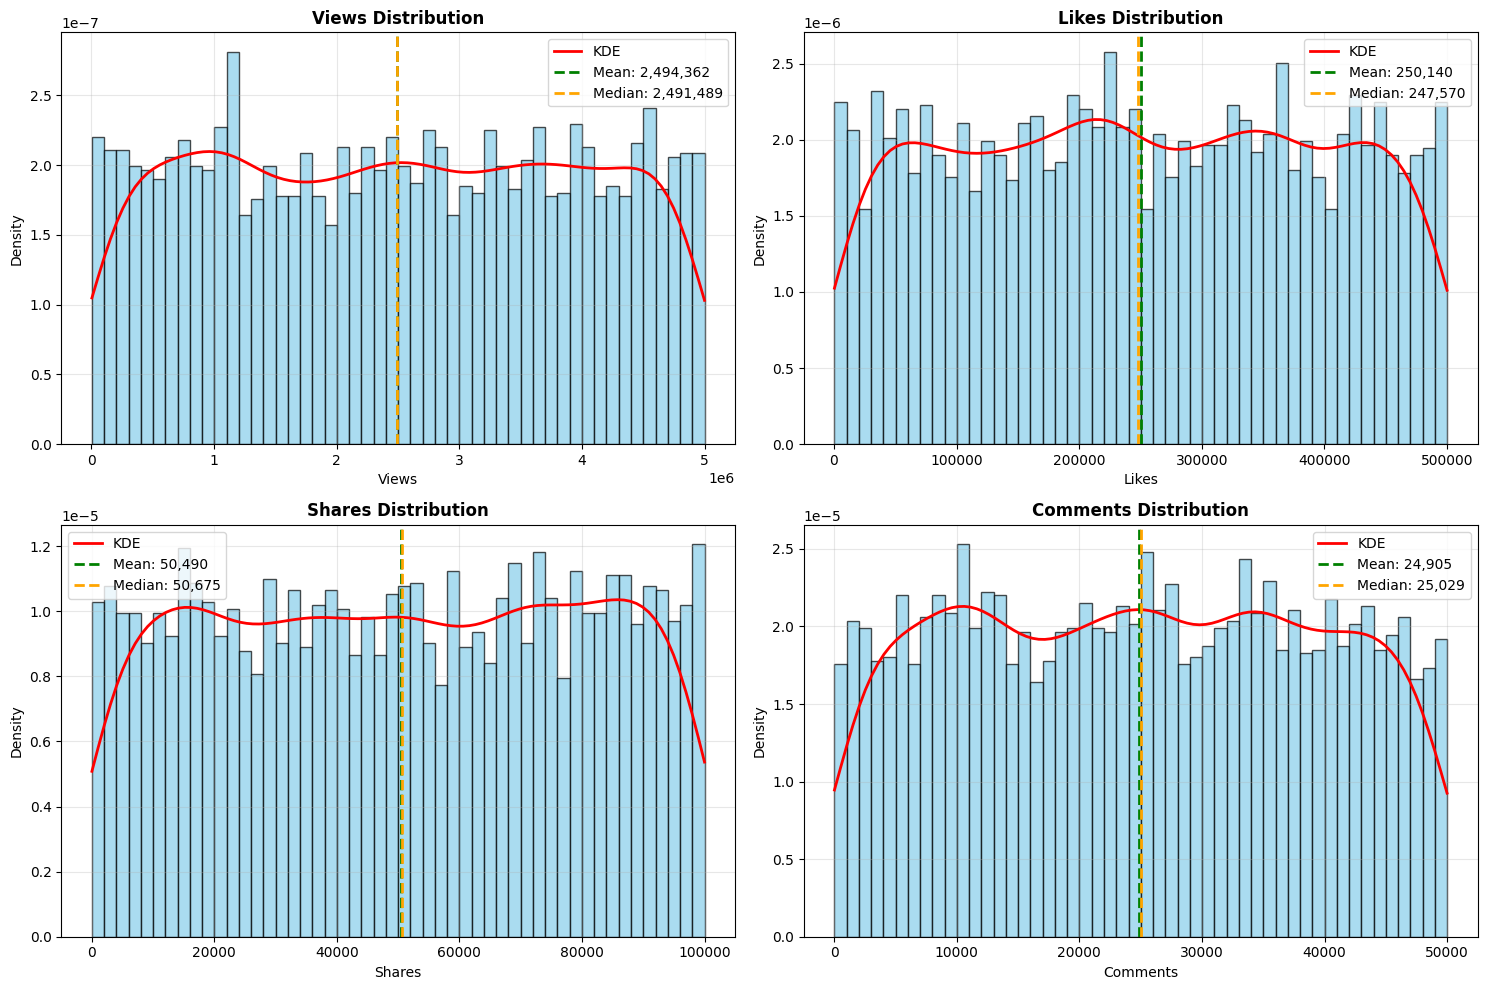

In [32]:
# Visualize distributions
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(engagement):
    data = train[col].dropna()
    
    # Histogram with KDE
    axes[idx].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 100)
    axes[idx].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Mean and median lines
    mean_val, median_val = data.mean(), data.median()
    axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:,.0f}')
    axes[idx].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f}')
    
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

After analyzing skewness, the distributions are approximately symmetric and the mean is close to the median. Therefore, missing values in `Views`, `Likes`, `Shares`, and `Comments` can be safely imputed using either the mean or median.


In [33]:
# List of engagement metrics we want to analyze
engagement_cols = ['Views', 'Likes', 'Shares', 'Comments']

# List of categorical features to test
categorical_cols = ['Platform', 'Hashtag', 'Content_Type', 'Region']

# Initialize a list to store ANOVA results
anova_results = []

# Loop over each engagement metric
for target in engagement_cols:
    best_p = 1          # Initialize the best p-value for this metric
    best_feature = None # Initialize the most influential categorical feature
    for col in categorical_cols:
        # Get unique categories, ignoring missing values
        categories = train[col].dropna().unique()
        if len(categories) < 2:
            continue  # Skip if the feature has less than 2 categories (ANOVA requires >=2)
        
        # Create groups of target values for each category
        groups = [train[train[col] == category][target].dropna() for category in categories]
        
        # Keep only groups with at least 2 values
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue  # Skip if not enough valid groups
        
        # Perform ANOVA test
        f_stat, p_value = f_oneway(*groups)
        
        # Update the most influential feature if the p-value is lower
        if p_value < best_p:
            best_p = p_value
            best_feature = col
    
    anova_results.append({
        'Engagement': target,
        'Most_Influential_Categorical': best_feature,
        'p-value': best_p
    })

anova_df = pd.DataFrame(anova_results)
print(anova_df)


  Engagement Most_Influential_Categorical   p-value
0      Views                     Platform  0.135754
1      Likes                     Platform  0.055399
2     Shares                     Platform  0.648325
3   Comments                     Platform  0.291129


## ANOVA Analysis of Categorical Features on Engagement Metrics

The purpose of this analysis is to identify which categorical feature has the most influence on each engagement metric (`Views`, `Likes`, `Shares`, `Comments`). 

### How the Test Works

- **ANOVA (Analysis of Variance)** compares the means of a numerical variable across different groups of a categorical variable.
- If the means differ significantly between groups, the categorical variable is considered influential on the numerical target.
- A **low p-value** indicates a statistically significant difference between group means, suggesting a strong influence.

### Steps in Our Analysis

1. For each engagement metric, we loop through all categorical features (`Platform`, `Hashtag`, `Content_Type`, `Region`).
2. For each categorical feature:
   - Groups of engagement values are created for each category.
   - Groups with too few values are ignored to ensure valid statistical testing.
   - ANOVA is performed to calculate the p-value.
3. The feature with the **lowest p-value** is selected as the **most influential categorical feature** for that engagement metric.

This approach allows us to identify which categorical variables most strongly affect user engagement on posts, helping guide feature selection for predictive modeling.


In [34]:
# Apply median imputation grouped by Platform, since it is the most influential categorical feature

for col in engagement:
    train[col] = train.groupby(['Platform'])[col].transform(
        lambda x: x.fillna(x.median())
    )
print("Missing values after imputation:")
print(train[engagement].isnull().sum())


Missing values after imputation:
Views       0
Likes       0
Shares      0
Comments    0
dtype: int64


## Outlier Detection in Numeric Variables

Outliers are extreme values that can distort analyses and models.  

**Method: IQR (Interquartile Range)**  
- Q1 = 25th percentile, Q3 = 75th percentile, IQR = Q3 - Q1  
- Lower Bound = Q1 - 1.5 * IQR, Upper Bound = Q3 + 1.5 * IQR  
- Values outside these bounds are considered outliers  

Detected outliers can be handled via **removal, capping, or imputation**.


In [35]:

# Select numeric columns
numeric_cols = ['Views', 'Likes', 'Shares', 'Comments']

# Dictionary to store outliers
outliers_dict = {}

for col in numeric_cols:
    # Calculate quartiles
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detect outliers
    outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)][col]
    
    # Store outliers in the dictionary
    outliers_dict[col] = outliers

for col, outliers in outliers_dict.items():
    print(f"{col}: {len(outliers)} outliers")


Views: 0 outliers
Likes: 0 outliers
Shares: 0 outliers
Comments: 0 outliers


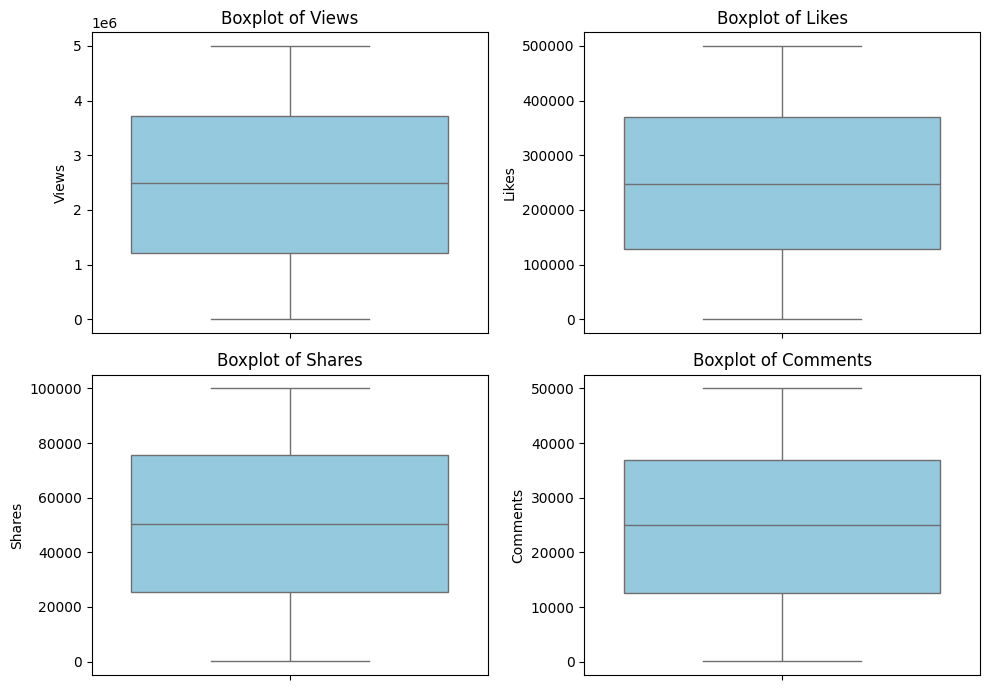

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each engagement metric and plot boxplot
for i, col in enumerate(engagement_cols):
    sns.boxplot(y=train[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Engagement Variables Summary

To better understand the distribution and scale of the engagement metrics, we generate a statistical summary of the four key variables:

- **Views**
- **Likes**
- **Shares**
- **Comments**

This descriptive analysis provides important insights such as:
- Minimum and maximum engagement levels  
- Average performance across posts  
- Variability and dispersion  
- Detection of potential anomalies or extreme values  

These statistics help evaluate data quality, guide feature engineering decisions, and prepare the dataset for modeling.


In [37]:
print(train.columns)


Index(['Post_ID', 'Pseudo_Caption', 'Post_Date', 'Platform', 'Hashtag',
       'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments',
       'Viral'],
      dtype='object')


In [38]:
# Select engagement variables
engagement_cols = ['Views', 'Likes', 'Shares', 'Comments']

# Display descriptive statistics
engagement_description = train[engagement_cols].describe().T
engagement_description


,count,mean,std,min,25%,50%,75%,max
Views,4365.0,2.494084e+06,1.441025e+06,4323.0,1203677.0,2488678.0,3718031.0,4999077.0
Likes,4365.0,2.501386e+05,1.427779e+05,490.0,129066.0,247723.0,369184.0,499922.0
Shares,4365.0,5.049055e+04,2.889955e+04,52.0,25552.0,50447.0,75452.0,99978.0
Comments,4365.0,2.490735e+04,1.409389e+04,32.0,12609.0,25073.0,36819.0,49986.0


**Convert Post_Date to DateTime**

Converting the Post_Date column to proper datetime format for time-series analysis.

In [39]:
print(train.columns)


Index(['Post_ID', 'Pseudo_Caption', 'Post_Date', 'Platform', 'Hashtag',
       'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments',
       'Viral'],
      dtype='object')


In [40]:
train['Post_Date'] = pd.to_datetime(train['Post_Date'], errors='coerce')
print(f"Date range: {train['Post_Date'].min()} to {train['Post_Date'].max()}")


Date range: 2022-01-01 00:00:00 to 2023-12-30 00:00:00


## Transformation & Feature Engineering

Extracting additional date-related features from the Post_Date column such as Year, Month, Day, and Day of Week.

In [41]:
# Extract temporal features from Post_Date
train['Year'] = train['Post_Date'].dt.year
train['Month'] = train['Post_Date'].dt.month
train['Day'] = train['Post_Date'].dt.day
train['DayOfWeek'] = train['Post_Date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Create is_weekend feature (1 if Saturday or Sunday, 0 otherwise)
train['Is_Weekend'] = train['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Drop original Post_Date column
train.drop(columns=['Post_Date'], inplace=True)


In [42]:
# Calculate proportion of viral posts per Content_Type
viral_rate = train.groupby('Content_Type')['Viral'].mean().sort_values(ascending=False)

# Most influential content type
best_content_type = viral_rate.index[0]
print(f"Most influential Content_Type on Viral: {best_content_type}")

Most influential Content_Type on Viral: video


In [43]:
train['Is_Video'] = (train['Content_Type'] == 'video').astype(int)
# Video content often receives higher engagement; this binary feature captures that effect.

In [44]:
# Advanced engagement metrics
train['Engagement_Rate'] = (train['Likes'] + train['Shares'] + train['Comments']) / (train['Views'] + 1)
train['Like_Rate'] = train['Likes'] / (train['Views'] + 1)
train['Share_Rate'] = train['Shares'] / (train['Views'] + 1)
train['Comment_Rate'] = train['Comments'] / (train['Views'] + 1)

# Log transformations reduce skewness and handles extreme values, improving model stability.
train['Log_Views'] = np.log1p(train['Views'])
train['Log_Likes'] = np.log1p(train['Likes'])
train['Log_Shares'] = np.log1p(train['Shares'])
train['Log_Comments'] = np.log1p(train['Comments'])


## Correlation Analysis Between Numerical Features and Viral Posts

Since our target variable **Viral** is binary (0 = not viral, 1 = viral), and our predictors include several **numerical features** (Views, Likes, Shares, Comments, etc.), we cannot use a standard Pearson correlation directly.

Instead, we apply the **Point-Biserial Correlation**, which is the appropriate statistical method for measuring the relationship between:

- a **binary variable** (Viral), and  
- a **continuous numerical variable** (engagement metrics).

This correlation helps us quantify how strongly each numerical feature contributes to a post becoming viral.  
A higher absolute value of the correlation indicates a stronger influence on the viral outcome.

The result is sorted by the magnitude of the correlation, allowing us to identify the **most impactful numerical variables** for predicting virality.


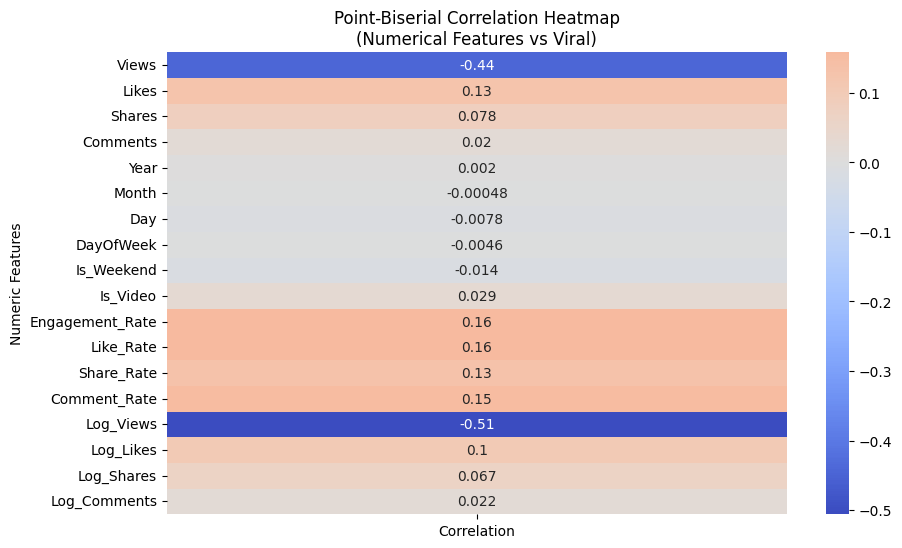

In [45]:

# Select numeric features
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Viral')

# Compute point-biserial correlations
correlations = {}

for col in numeric_cols:
    corr, p_value = pointbiserialr(train['Viral'], train[col])
    correlations[col] = corr

# Convert to DataFrame
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Point-Biserial Correlation Heatmap\n(Numerical Features vs Viral)")
plt.ylabel("Numeric Features")
plt.show()


In [46]:
train['Virality_Score'] = (train['Shares'] * 3 + train['Comments'] * 2 + train['Likes']) / (train['Views'] + 1)
# Justification: Weighted metric that emphasizes shares and comments, which are more valuable for virality.

In [47]:
# Engagement ratios
train['Like_Ratio'] = train['Likes'] / (train['Likes'] + train['Shares'] + train['Comments'] + 1)
train['Share_Ratio'] = train['Shares'] / (train['Likes'] + train['Shares'] + train['Comments'] + 1)
# Justification: Measures the proportion of likes or shares relative to total engagement, helping capture engagement patterns.

# Interaction features
train['Likes_X_Shares'] = train['Likes'] * train['Shares']

## Data Analysis and Visualization

## Interactive Categorical Bar Chart

This chart visualizes the distribution of a selected categorical variable from the dataset.  

- Each bar represents the **count of posts** for a specific category.  
- The interactive selector allows you to **choose which categorical variable** to display (`Platform`, `Content_Type`, `Region`, `Hashtag`).  
- This helps quickly identify the **most frequent categories** and compare their representation in the dataset.


In [48]:
def plot_categorical(var):
    plt.figure(figsize=(8,5))
    order = train[var].value_counts().index
    sns.countplot(data=train, x=var, order=order, color='coral')
    plt.title(f'Bar Chart of {var}')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.show()

interact(plot_categorical, var=categorical_cols)

interactive(children=(Dropdown(description='var', options=('Platform', 'Hashtag', 'Content_Type', 'Region'), v…

<function __main__.plot_categorical(var)>

In [49]:
def plot_viral_pie(variable):
    # Compute viral proportion per category
    data = train.groupby(variable)['Viral'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(6,6))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
    plt.title(f'Proportion of Viral Posts by {variable}')
    plt.show()

interact(plot_viral_pie, variable=categorical_cols)

interactive(children=(Dropdown(description='variable', options=('Platform', 'Hashtag', 'Content_Type', 'Region…

<function __main__.plot_viral_pie(variable)>

In [50]:

def plot_viral_sum(var):
    # Sum of viral posts per category
    data = train.groupby(var)['Viral'].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(8,5))
    # Use a single color to avoid FutureWarning
    sns.barplot(x=data.index, y=data.values, color='mediumslateblue')
    plt.ylabel('Total Viral Posts')
    plt.xlabel(var)
    plt.title(f'Total Viral Posts by {var}')
    plt.show()

interact(plot_viral_sum, var=categorical_cols)

interactive(children=(Dropdown(description='var', options=('Platform', 'Hashtag', 'Content_Type', 'Region'), v…

<function __main__.plot_viral_sum(var)>

### Scatter Plot of Numerical Features vs Viral

This scatter plot visualizes the relationship between two numerical variables while highlighting viral (Viral=1) and non-viral (Viral=0) posts. Using a sample of 100 points keeps the chart clear and readable.  

It helps to:
- Identify patterns or clusters of viral posts.
- Compare interactions between numerical metrics (Views, Likes, Shares, Comments).
- Spot variables that may influence the likelihood of a post going viral.


In [51]:
numeric_cols = ['Views', 'Likes', 'Shares', 'Comments']

def scatter_numeric(x_var, y_var):
    # Sample 100 points to keep the chart clear
    sample = train.sample(100, random_state=42)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x=x_var, 
        y=y_var, 
        hue='Viral', 
        data=sample, 
        alpha=0.7, 
        palette=['blue', 'red']
    )
    plt.title(f'{x_var} vs {y_var} colored by Viral (sample of 100)')
    plt.show()

interact(scatter_numeric, x_var=numeric_cols, y_var=numeric_cols)


interactive(children=(Dropdown(description='x_var', options=('Views', 'Likes', 'Shares', 'Comments'), value='V…

<function __main__.scatter_numeric(x_var, y_var)>

## Line Chart for Temporal Trends

We use line charts to visualize how engagement metrics evolve over time or across temporal features.  

- Each line represents the trend of a selected metric (e.g., Views, Likes, Shares, Comments).  
- This allows us to detect **patterns, peaks, and seasonal effects** in the data.  
- By grouping data by temporal features such as Month, DayOfWeek, or is_weekend, we can **analyze how engagement changes over time**.  
- Line charts make it easy to **compare trends across metrics** and identify periods of high or low activity.


In [52]:
def plot_engagement_temporal(metric='Views', temporal='Month'):
    # Group by the selected temporal feature and sum engagement
    df = train.groupby(temporal)[metric].sum().reset_index()
    
    plt.figure(figsize=(10,5))
    plt.plot(df[temporal], df[metric], marker='o', color='mediumslateblue')
    plt.title(f'{metric} over {temporal}')
    plt.xlabel(temporal)
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

# Interactive widget
temporal_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'Is_Weekend']
interact(plot_engagement_temporal, metric=engagement_cols, temporal=temporal_features)

interactive(children=(Dropdown(description='metric', options=('Views', 'Likes', 'Shares', 'Comments'), value='…

<function __main__.plot_engagement_temporal(metric='Views', temporal='Month')>

## Analysis of the Best Day to Post

In this analysis, we aim to identify the optimal days for posting content to maximize virality.  

- We use the `Viral` column (0/1) as the target metric to determine which posts become viral.  
- The dataset is grouped by `Platform`, `Content_Type`, and `DayOfWeek` to calculate the **average proportion of viral posts** for each combination.  
- This allows us to see patterns and trends: certain days of the week may perform better depending on the **platform** and **type of content**.  
- A heatmap or table can be used to **visualize the results**, making it easy to spot the **best day(s) to post** for each platform and content type.  
- This analysis helps in **planning and optimizing posting schedules** to increase engagement and virality.


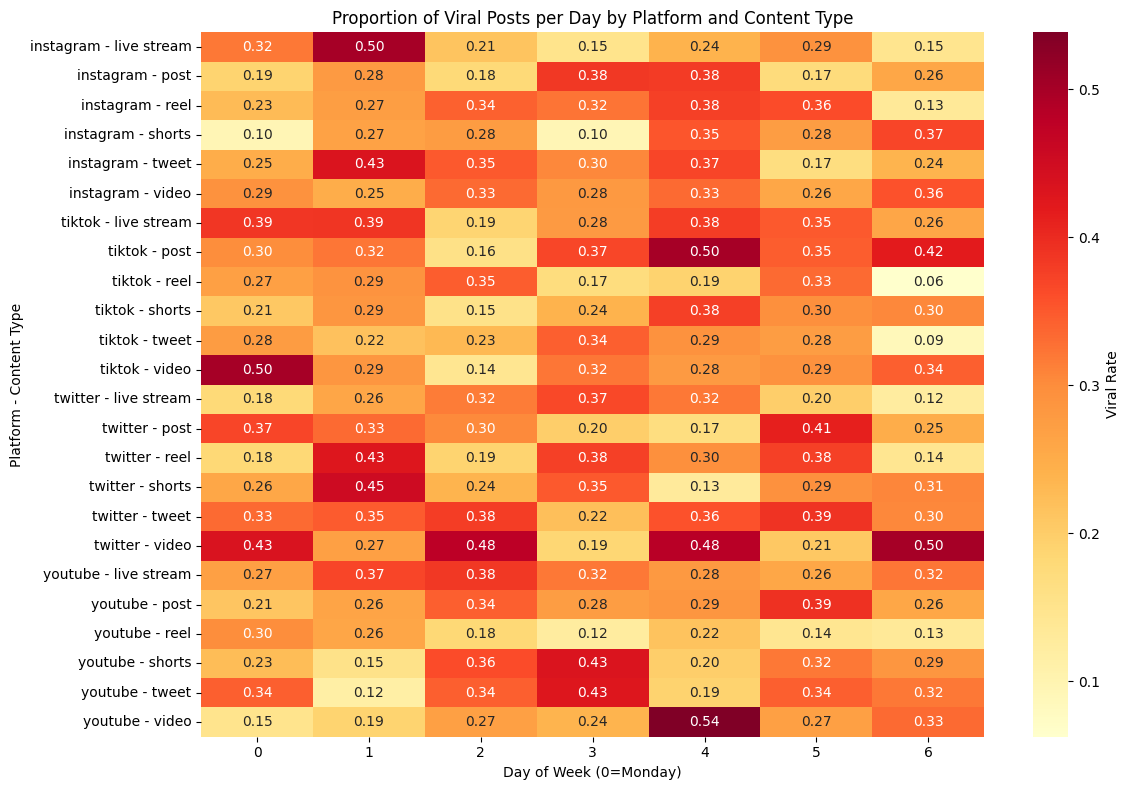

      Platform Content_Type  DayOfWeek     Viral
1    instagram  live stream          1  0.500000
10   instagram         post          3  0.384615
18   instagram         reel          4  0.375000
27   instagram       shorts          6  0.370370
29   instagram        tweet          1  0.433333
41   instagram        video          6  0.357143
43      tiktok  live stream          1  0.388889
53      tiktok         post          4  0.500000
58      tiktok         reel          2  0.346154
67      tiktok       shorts          4  0.375000
73      tiktok        tweet          3  0.344828
77      tiktok        video          0  0.500000
87     twitter  live stream          3  0.366667
96     twitter         post          5  0.413793
99     twitter         reel          1  0.428571
106    twitter       shorts          1  0.454545
117    twitter        tweet          5  0.391304
125    twitter        video          6  0.500000
128    youtube  live stream          2  0.384615
138    youtube      

In [53]:
# Group by Platform, Content_Type, DayOfWeek and compute mean viral rate
viral_day_df = train.groupby(['Platform', 'Content_Type', 'DayOfWeek'])['Viral'].mean().reset_index()

# Create a combined column for Y-axis
viral_day_df['Platform_Content'] = viral_day_df['Platform'] + ' - ' + viral_day_df['Content_Type']

# Pivot table for heatmap
pivot = viral_day_df.pivot(index='Platform_Content', columns='DayOfWeek', values='Viral')

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Viral Rate'})
plt.title('Proportion of Viral Posts per Day by Platform and Content Type')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Platform - Content Type')
plt.tight_layout()
plt.show()

# identify the best day for each Platform + Content_Type
best_days = viral_day_df.loc[viral_day_df.groupby(['Platform','Content_Type'])['Viral'].idxmax()]
print(best_days[['Platform','Content_Type','DayOfWeek','Viral']])

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a dataset with many features into a smaller set of uncorrelated variables called principal components.  

### Purpose and Benefits:
- **Reduce Complexity**: PCA helps simplify datasets by reducing the number of features while retaining most of the variance.
- **Visualize High-Dimensional Data**: By projecting data into 2 or 3 principal components, we can visualize complex datasets and identify patterns or clusters.
- **Detect Separation Between Classes**: PCA can highlight how different classes (e.g., `Viral` vs `Non-Viral` posts) are distributed in the reduced feature space.
- **Improve Model Efficiency**: Reducing dimensions can help machine learning models train faster and sometimes improve performance by removing noise and redundant information.

In this analysis, PCA is used to visualize the separation between viral and non-viral posts, providing insights into which features contribute most to variance and helping understand the structure of the dataset.


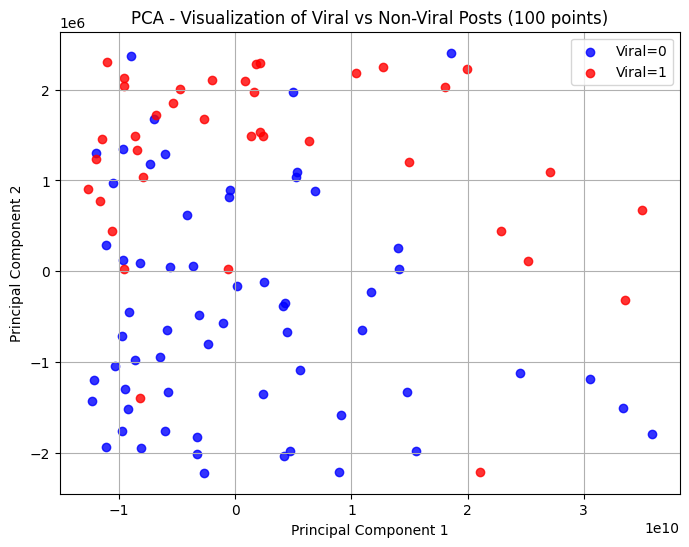

In [54]:
# Steps to perform PCA from scratch

# 1. Select numerical features
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Viral')
X = train[numeric_cols].values

# 2. Center the data (subtract mean)
X_centered = X - np.mean(X, axis=0)

# 3. Compute covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# 4. Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvectors by descending eigenvalues
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_idx]
eigenvalues = eigenvalues[sorted_idx]

# 5. Project data onto first 2 principal components
PCs = X_centered.dot(eigenvectors[:, :2])  # ensure it's numpy array

pca_df = pd.DataFrame({
    'PC1': PCs[:,0],
    'PC2': PCs[:,1],
    'Viral': train['Viral'].values
})


# 6. Sample only 100 points for visualization
pca_sample = pca_df.sample(100, random_state=seed)

# 7. Plot
plt.figure(figsize=(8,6))
for label, color in zip([0,1], ['blue','red']):
    subset = pca_sample[pca_sample['Viral'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Viral={label}', alpha=0.8, c=color)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Visualization of Viral vs Non-Viral Posts (100 points)')
plt.legend()
plt.grid(True)
plt.show()


## Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a **supervised dimensionality reduction** technique that projects high-dimensional data onto a lower-dimensional space while maximizing **class separability**. Unlike PCA, LDA uses class labels to find the directions that best separate the classes.

- **Dimensionality Reduction:** Reduces the number of features while keeping the most discriminative information.  
- **Class Separation:** Projects data so that different classes are well-separated, improving classification accuracy.  
- **Faster and Efficient Models:** Reduces computational cost and helps classifiers train faster.  
- **Visualization:** Helps visualize the separation between classes in 1D or 2D space.

**In short:** LDA transforms features to optimize classification by reducing dimensions and highlighting differences between classes.


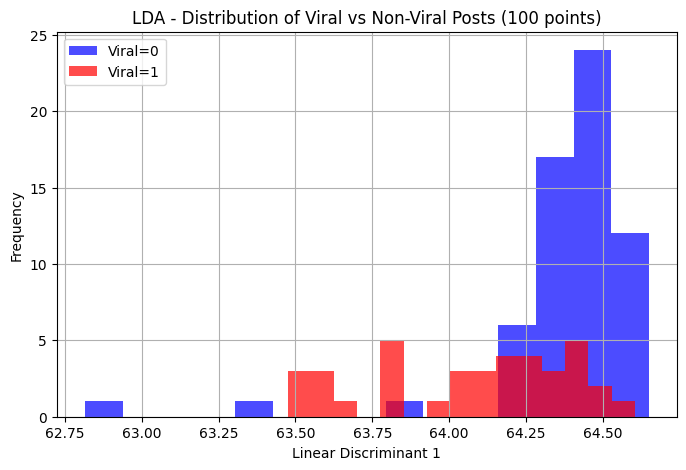

In [55]:

numeric_cols = train.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Viral')
X = train[numeric_cols].values
y = train['Viral'].values

# Compute class means

classes = np.unique(y)
mean_vectors = [np.mean(X[y==cls], axis=0) for cls in classes]

# Within-class scatter matrix
n_features = X.shape[1]
Sw = np.zeros((n_features, n_features))
for cls, mv in zip(classes, mean_vectors):
    Sw += np.cov(X[y==cls].T, bias=True) * X[y==cls].shape[0]

# Between-class scatter matrix
overall_mean = np.mean(X, axis=0)
Sb = np.zeros((n_features, n_features))
for cls, mv in zip(classes, mean_vectors):
    n_cls = X[y==cls].shape[0]
    diff = (mv - overall_mean).reshape(n_features,1)
    Sb += n_cls * diff.dot(diff.T)

eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
eigvec = np.real(eigvecs[:, np.argmax(eigvals)])

#  Project data onto LD1
X_lda = np.real(X.dot(eigvec)) 

lda_df = pd.DataFrame({'LD1': X_lda, 'Viral': y}).sample(100, random_state=42)

plt.figure(figsize=(8,5))
for label, color in zip([0,1], ['blue','red']):
    subset = lda_df[lda_df['Viral'] == label]
    plt.hist(subset['LD1'], bins=15, alpha=0.7, label=f'Viral={label}', color=color)
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Frequency')
plt.title('LDA - Distribution of Viral vs Non-Viral Posts (100 points)')
plt.legend()
plt.grid(True)
plt.show()


## Chi-square Analysis for Categorical Variables vs Viral

The Chi-square test measures the association between categorical features and the binary target `Viral`.  
- **Chi2 statistic** shows the strength of the association.  
- **p-value** indicates statistical significance (p < 0.05).  
- **Direction of effect** shows which categories favor or reduce viral posts.

**Insights:**  
- No variable is statistically significant, but trends exist:  
  - `#dance` and `video` favor virality.  
  - `#fitness` and `reel` reduce virality.  
  - `Brazil` slightly higher viral rate than `USA`.  
  - Twitter slightly more viral than YouTube.

**Conclusion:**  
Chi-square helps identify influential categories and guides feature engineering for predictive modeling.


In [56]:

chi_results = []

for col in categorical_cols:
    table = pd.crosstab(train[col], train['Viral'])
    chi2, p, _, _ = chi2_contingency(table)

    effect = table[1] / table.sum(axis=1)
    most_positive = effect.idxmax()
    most_negative = effect.idxmin()
    
    chi_results.append({
        'Variable': col,
        'Chi2': chi2,
        'p-value': p,
        'Most_Positive_Category': most_positive,
        'Most_Negative_Category': most_negative
    })

chi_df = pd.DataFrame(chi_results).sort_values('Chi2', ascending=False)
chi_df


,Variable,Chi2,p-value,Most_Positive_Category,Most_Negative_Category
1,Hashtag,12.779952,0.172819,#dance,#fitness
2,Content_Type,8.367940,0.137090,video,reel
3,Region,5.890903,0.552544,brazil,usa
0,Platform,1.451097,0.693602,twitter,youtube


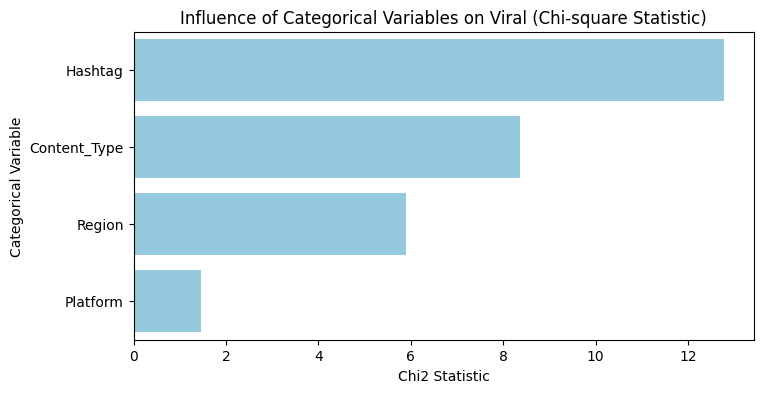

In [57]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=chi_df.sort_values('Chi2', ascending=False), 
    x='Chi2', 
    y='Variable', 
    color='skyblue'  # single color instead of palette
)
plt.title('Influence of Categorical Variables on Viral (Chi-square Statistic)')
plt.xlabel('Chi2 Statistic')
plt.ylabel('Categorical Variable')
plt.show()

## Model Development and Optimization

In this section, we focus on **building and fine-tuning predictive models** for viral posts. The goal is to select the most suitable algorithms, engineer relevant features, and optimize hyperparameters to achieve the **best possible performance**.  

Key steps include:
- Feature selection and engineering
- Handling imbalanced classes
- Model training and evaluation
- Hyperparameter tuning to improve metrics like F1-score, accuracy, and recall
- Ensuring interpretability and robustness of the model


In [58]:
# Prepare data
X = train.drop(columns=['Post_ID', 'Viral', 'Pseudo_Caption']).copy()
y = train['Viral']


In [59]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: 3492
Testing set size: 873

Class distribution in training set:
Viral
0    0.713631
1    0.286369
Name: proportion, dtype: float64


## Importance of Normalization

Normalization (or scaling) is a crucial preprocessing step for many machine learning algorithms.  
It ensures that all numeric features have the same scale, preventing features with large values from dominating the model.  

- **Algorithms affected:** KNN, SVM, Logistic Regression, Gradient Descent-based methods.  
- **Algorithms not affected:** Tree-based models like Random Forest or XGBoost.  

Normalization improves **training stability**, **convergence speed**, and can lead to **better predictive performance**.


In [60]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['Views', 'Likes', 'Shares', 'Comments']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

**Apply Target Encoding for Categorical Variables**

Target encoding replaces categories with the mean of the target variable for that category, capturing more information than one-hot encoding.

In [61]:
# Target encode categorical variables using training data only
categorical_cols = ['Platform', 'Content_Type', 'Hashtag', 'Region']

for col in categorical_cols:
    # Calculate mean target per category in training data
    target_means = y_train.groupby(X_train[col]).mean()
    
    # Apply to both train and test
    X_train[col + '_encoded'] = X_train[col].map(target_means)
    X_test[col + '_encoded'] = X_test[col].map(target_means)
    
    # Fill NaN with overall mean (for categories not in training)
    overall_mean = y_train.mean()
    X_train[col + '_encoded'] = X_train[col + '_encoded'].fillna(overall_mean)
    X_test[col + '_encoded'] = X_test[col + '_encoded'].fillna(overall_mean)
    
    # Drop original categorical column
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)


### Handling Class Imbalance with ADASYN

Our dataset is imbalanced, with fewer viral posts (`Viral=1`) than non-viral posts (`Viral=0`). To address this, we use **ADASYN (Adaptive Synthetic Sampling)** to generate synthetic samples for the minority class.  

This helps to:
- Balance the class distribution in the training set.
- Make the model more sensitive to viral posts.
- Improve performance metrics like **F1-score** and **recall** for the minority class.
- Focus on harder-to-learn minority samples, leading to better generalization.


In [62]:
# Apply ADASYN to balance the classes
adasyn = ADASYN(random_state=seed)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print(f"Features after encoding: {X_train.shape[1]}")
print(f"Training samples after ADASYN: {X_train_resampled.shape[0]}")
print(f"Class distribution: {y_train_resampled.value_counts().to_dict()}")

Features after encoding: 26
Training samples after ADASYN: 4990
Class distribution: {1: 2498, 0: 2492}


## Logistic Regression Performance

We applied a Logistic Regression model from scratch to predict post virality.  
The model achieved a **Macro F1-score of 0.4164**, indicating moderate performance in distinguishing viral vs non-viral posts.  

- **Interpretation:** The model captures some patterns in the data, but there is room for improvement, possibly through feature engineering, data balancing, or using more advanced algorithms.


In [63]:
class LogisticRegression:
    def __init__(self, lr=0.001, epochs=2000):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None

    def sigmoid(self, z):
        # Prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)
        n_samples, n_features = X.shape

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            z = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(z)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict_proba(self, X):
        X = np.array(X, dtype=float)
        z = np.dot(X, self.w) + self.b
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

    def f1_macro(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred, average='macro')



logreg = LogisticRegression(lr=0.01, epochs=1000)
logreg.fit(X_train_resampled, y_train_resampled)
f1_logreg = logreg.f1_macro(X_test, y_test)
print(f"Logistic Regression Macro F1-score: {f1_logreg:.4f}")

Logistic Regression Macro F1-score: 0.4164


## K-Nearest Neighbors (KNN) Performance

We implemented a K-Nearest Neighbors (KNN) classifier from scratch to predict post virality.  
The model achieved a **Macro F1-score of 0.4886**, showing a better ability than Logistic Regression to distinguish viral from non-viral posts.  

- **Interpretation:** KNN leverages similarity between posts based on features. While it improves over Logistic Regression, further enhancements could include feature scaling, hyperparameter tuning, or advanced sampling techniques.


In [64]:
class KNN:
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
    
    def predict(self, X_test):
        X_test = np.array(X_test)
        # Compute pairwise Euclidean distances (vectorized)
        dists = np.sqrt(
            np.sum(X_test**2, axis=1)[:, np.newaxis] + 
            np.sum(self.X_train**2, axis=1)[np.newaxis, :] - 
            2 * X_test.dot(self.X_train.T)
        )
        
        # Get k nearest neighbors
        k_indices = np.argsort(dists, axis=1)[:, :self.k]
        k_labels = self.y_train[k_indices]  # shape (num_test, k)
        
        # Majority vote for each test sample
        predictions = np.array([Counter(row).most_common(1)[0][0] for row in k_labels])
        return predictions
    
    def f1_macro(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return f1_score(y_test, y_pred, average='macro')

knn = KNN(k=15)
knn.fit(X_train_resampled, y_train_resampled)
f1_knn = knn.f1_macro(X_test, y_test)
print(f"KNN Macro F1-score: {f1_knn:.4f}")

KNN Macro F1-score: 0.4886


## Support Vector Machine (SVM) Performance

We applied a Support Vector Machine (SVM) classifier to predict post virality.  
The model achieved a **Macro F1-score of 0.5412**, outperforming both Logistic Regression and KNN.  

- **Interpretation:** SVM finds the optimal hyperplane that separates viral from non-viral posts in the feature space. Its higher F1-score indicates better class separation and generalization. Proper feature encoding and handling of class imbalance contributed to this performance.


In [65]:

svm_clf = SVC(kernel='rbf', random_state=42, class_weight='balanced')

# Train
svm_clf.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = svm_clf.predict(X_test)

# Evaluate
f1 = f1_score(y_test, y_pred, average='macro')
print(f"SVM Macro F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


SVM Macro F1-score: 0.5412

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.59      0.66       623
           1       0.34      0.54      0.42       250

    accuracy                           0.57       873
   macro avg       0.55      0.56      0.54       873
weighted avg       0.64      0.57      0.59       873



## Tree-Based Algorithms and Scaling

Tree-based models like Random Forest or Gradient Boosting **do not require feature scaling**.  
These algorithms split data based on thresholds and relative ordering of feature values, so normalization or standardization does not impact their performance.


In [66]:
X = train.drop(columns=['Post_ID', 'Viral', 'Pseudo_Caption']).copy()
y = train['Viral']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

categorical_cols = ['Platform', 'Content_Type', 'Hashtag', 'Region']

for col in categorical_cols:
    target_means = y_train.groupby(X_train[col]).mean()
    X_train[col + '_encoded'] = X_train[col].map(target_means)
    X_test[col + '_encoded'] = X_test[col].map(target_means)
    overall_mean = y_train.mean()
    X_train[col + '_encoded'] = X_train[col + '_encoded'].fillna(overall_mean)
    X_test[col + '_encoded'] = X_test[col + '_encoded'].fillna(overall_mean)
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

adasyn = ADASYN(random_state=seed)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


## Random Forest Performance

The Random Forest classifier achieved a **Macro F1-score of 0.83**, outperforming other models like Logistic Regression, KNN, and SVM.  
Its strong performance is due to its ensemble nature, handling non-linearities, and not requiring feature scaling.


In [67]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,       
    random_state=seed,
    n_jobs=-1  
)

rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Macro F1-score: 0.8299138254027726

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       623
           1       0.80      0.71      0.75       250

    accuracy                           0.87       873
   macro avg       0.84      0.82      0.83       873
weighted avg       0.86      0.87      0.86       873



## XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is an ensemble learning method based on gradient boosting of decision trees.  
It works by sequentially building trees that correct the errors of previous trees, optimizing a differentiable loss function.  

**Why XGBoost was chosen:**  
- Handles non-linear relationships and interactions between features effectively.  
- Robust to missing data and outliers.  
- Often achieves high predictive performance on tabular datasets.  
- Does not require feature scaling, making it suitable for our encoded and numeric features.


In [68]:
# Train initial XGBoost to get feature importances
xgb_classifier = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.03,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=seed,
    eval_metric='logloss'
)

xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Get feature importances and select top 10
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(15).to_string(index=False))


Top 10 most important features:
             feature  importance
      Virality_Score    0.292780
     Engagement_Rate    0.148482
Content_Type_encoded    0.058643
           Like_Rate    0.057747
    Platform_encoded    0.055813
     Hashtag_encoded    0.039683
                Year    0.034300
            Is_Video    0.028680
          Is_Weekend    0.026961
          Share_Rate    0.026829
      Region_encoded    0.023298
           Log_Views    0.018664
        Comment_Rate    0.017636
           Log_Likes    0.016890
          Like_Ratio    0.016669


In [69]:
# Train final model with top 10 features
top_features = feature_importance.head(10)['feature'].values
X_train_selected = X_train_resampled[top_features]
X_test_selected = X_test[top_features]

# Final optimized model
model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.03,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=seed,
    eval_metric='logloss'
)

model.fit(X_train_selected, y_train_resampled)

# Evaluate
y_pred_train = model.predict(X_train[top_features])
y_pred_test = model.predict(X_test_selected)

test_f1 = f1_score(y_test, y_pred_test, average='macro')

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Testing Macro F1 Score:  {test_f1:.4f}")
print("="*60)


FINAL MODEL PERFORMANCE
Testing Macro F1 Score:  0.8402


C:\Users\omar1\AppData\Local\Temp\ipykernel_18972\2553571277.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_selected, plot_type="bar")


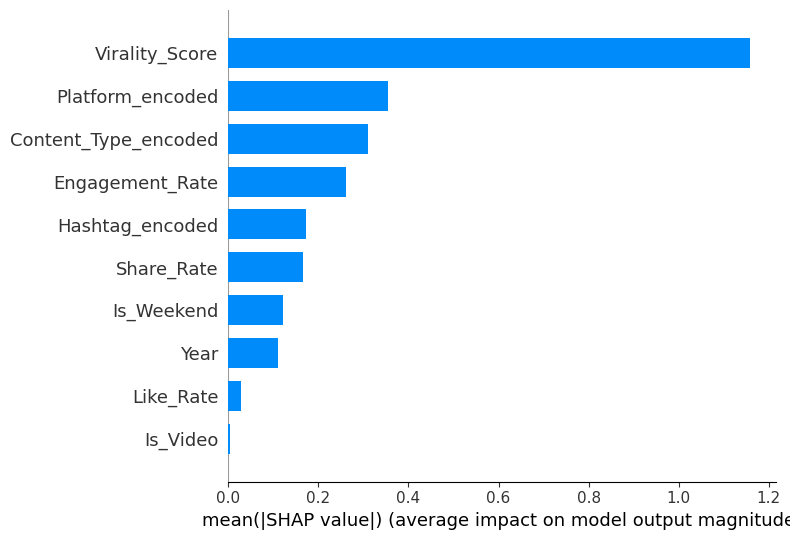

C:\Users\omar1\AppData\Local\Temp\ipykernel_18972\2553571277.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_selected)


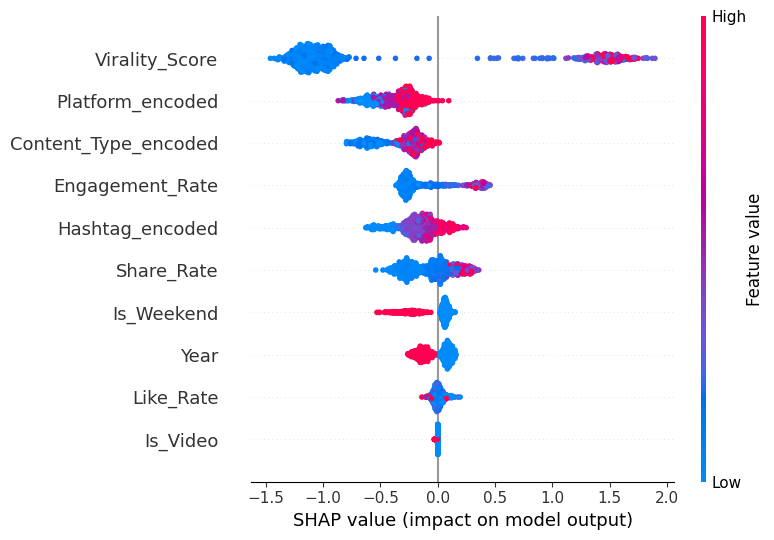

In [70]:
import shap

# Initialize the explainer
explainer = shap.Explainer(model, X_train_selected)
shap_values = explainer(X_test_selected)

shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

shap.summary_plot(shap_values, X_test_selected)


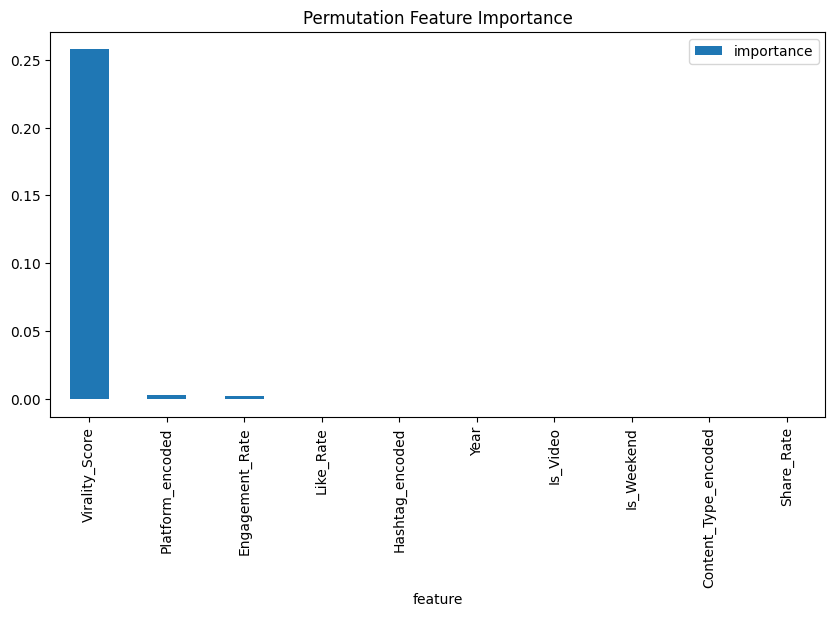

In [71]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_selected, y_test, n_repeats=10, random_state=seed)
perm_df = pd.DataFrame({'feature': X_test_selected.columns, 'importance': result.importances_mean})
perm_df.sort_values('importance', ascending=False).plot.bar(x='feature', y='importance', figsize=(10,5), title="Permutation Feature Importance")
plt.show()


# Integration of Embeddings

In addition to the structured features, we incorporated textual information from post captions using embeddings. Embeddings transform text into numerical vectors that capture semantic meaning, allowing the model to understand similarities and relationships between posts.


In [72]:



# --- Split features and target ---
X = train.drop(columns=['Post_ID', 'Viral']).copy()
y = train['Viral']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

# --- Encode categorical variables ---
categorical_cols = ['Platform', 'Content_Type', 'Hashtag', 'Region']

for col in categorical_cols:
    target_means = y_train.groupby(X_train[col]).mean()
    X_train[col + '_encoded'] = X_train[col].map(target_means)
    X_test[col + '_encoded'] = X_test[col].map(target_means)
    overall_mean = y_train.mean()
    X_train[col + '_encoded'] = X_train[col + '_encoded'].fillna(overall_mean)
    X_test[col + '_encoded'] = X_test[col + '_encoded'].fillna(overall_mean)
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

# --- Embed Pseudo_Caption ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# Transform training captions
caption_train_emb = model.encode(X_train['Pseudo_Caption'].tolist())
caption_test_emb = model.encode(X_test['Pseudo_Caption'].tolist())

pca = PCA(n_components=50, random_state=seed)
caption_train_pca = pca.fit_transform(caption_train_emb)
caption_test_pca = pca.transform(caption_test_emb)

for i in range(caption_train_pca.shape[1]):
    X_train[f'caption_{i}'] = caption_train_pca[:, i]
    X_test[f'caption_{i}'] = caption_test_pca[:, i]

X_train.drop(columns=['Pseudo_Caption'], inplace=True)
X_test.drop(columns=['Pseudo_Caption'], inplace=True)

# --- Scale numeric features ---
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# --- Apply ADASYN to balance classes ---
adasyn = ADASYN(random_state=seed)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# --- Train XGBoost on final dataset ---
xgb_classifier = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.03,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=seed,
    eval_metric='logloss'
)

xgb_classifier.fit(X_train_resampled, y_train_resampled)

# --- Evaluate ---
y_pred_test = xgb_classifier.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f"XGBoost Testing Macro F1 Score: {test_f1:.4f}")


XGBoost Testing Macro F1 Score: 0.8364


### Impact of Text Embeddings on Model Performance

After integrating **SentenceTransformer embeddings** for the `Pseudo_Caption` field and reducing their dimensionality with PCA, the model achieved an **F1 score of 0.8364**.  
However, this performance is **slightly lower** than the XGBoost model trained **without** textual embeddings **F1 score of 0.8402**.

The main reason is that the semantic information contained in the captions is **already captured indirectly** through other engineered features such as **Region, Hashtag, Platform, and Content Type**. These features strongly encode the behavior and virality patterns of posts, making the additional embedding vectors less impactful and sometimes even adding noise.

**Conclusion:**  
The **best-performing model** remains **XGBoost without embeddings F1 0.8402**, as it leverages existing structured features more efficiently and avoids unnecessary dimensional complexity.
